# Frequency Tagging

In [121]:
import mne
import pandas as pd
import numpy as np
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper, AverageTFR
from mne_connectivity import spectral_connectivity_epochs, spectral_connectivity_time
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

## Simulation

Check out Lecture 2! Especially the evoked and induced bit.

## High frequency stimulation

In [2]:
datapath = "/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/Lecture5_FrequencyTagging/data/"

raw = mne.io.read_raw_egi(datapath + '45048.RAW', preload = True)
raw.drop_channels(['E30', 'E192', 'E257'])
#raw.rename_channels({'E257': 'Cz'})
raw.set_montage('EGI_256')
raw.notch_filter(freqs=(50, 100, 150, 200))
raw.filter(2, 48)
#raw.set_eeg_reference(ref_channels="average")

Reading EGI header from /Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/Lecture5_FrequencyTagging/data/45048.RAW...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {DIN1} ...
Reading 0 ... 367599  =      0.000 ...   367.599 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.3s


<RawEGI | 45048.RAW, 259 x 367600 (367.6 s), ~726.7 MB, data loaded>

In [3]:
evts = mne.find_events(raw)
epochs= mne.Epochs(raw, evts, tmin=-1, tmax=3, preload = True)

125 events found
Event IDs: [1 2 3]
Not setting metadata
125 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 125 events and 4001 original time points ...
0 bad epochs dropped


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


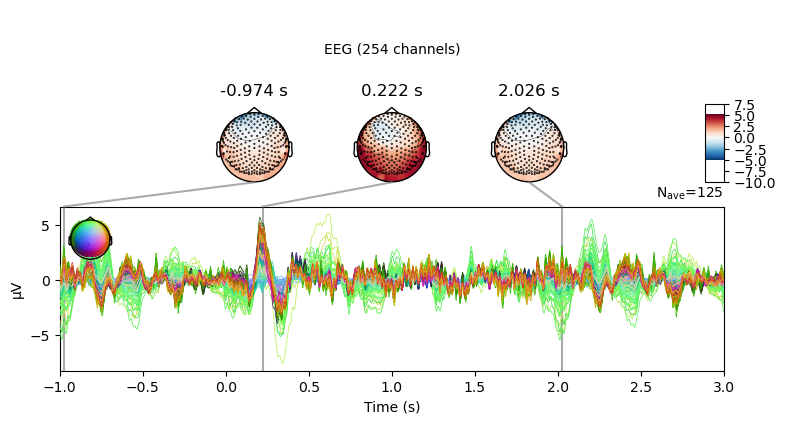

In [4]:
evoked = epochs.copy().average()
evoked.plot_joint();


Effective window size : 2.001 (s)


/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/methcogneurocode/.venv/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


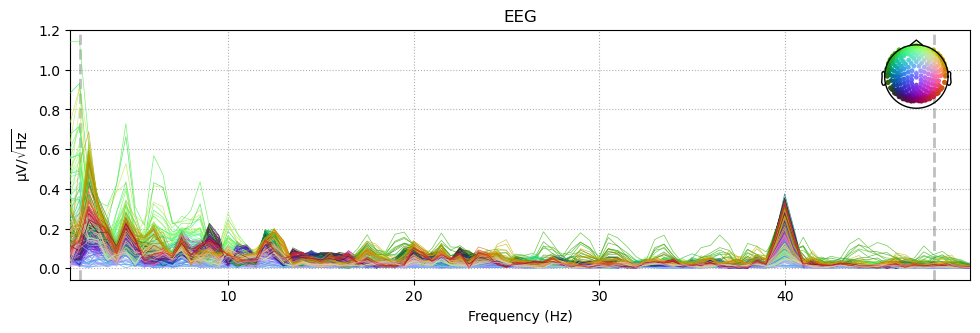

In [5]:
psdevoked = evoked.copy().crop(.5, 2.5).compute_psd(method='welch', fmin=1, fmax=50)
psdevoked.plot(dB = False);

Need more than one channel to make topography for eeg. Disabling interactivity.


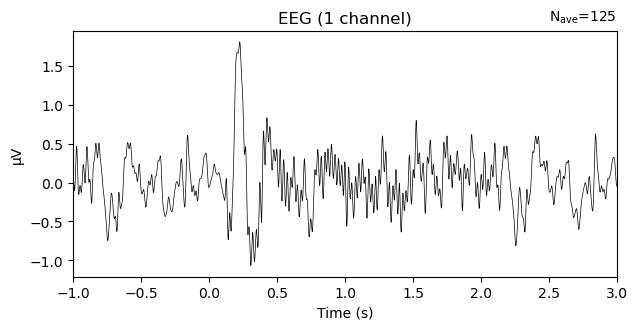

In [6]:
ind40Hz = (np.abs(psdevoked.freqs - 40)).argmin()
evoked.plot(picks = evoked.ch_names[ind40Hz]);



### Derive SSR from evoked power TFR

In [7]:
freqs = np.arange(2, 48) 

tfr_evoked = tfr_multitaper(
    evoked,
    freqs=freqs,
    n_cycles=freqs / 2, #500 ms windo 
    time_bandwidth=2,
    use_fft=True,
    return_itc=False,
    decim=2,
)

tfr_induced = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=freqs / 2, #500 ms windo 
    time_bandwidth=2,
    use_fft=True,
    return_itc=True,
    decim=2,
)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   13.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  2.1min


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: percent)


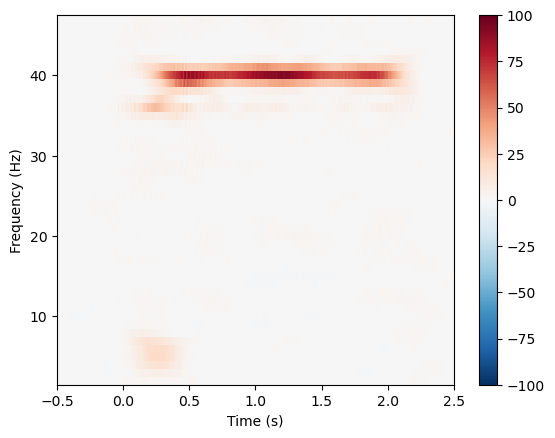

[<Figure size 640x480 with 2 Axes>]

In [8]:
tfr_evoked.plot(
    picks=['eeg'],
    tmin=-0.5, tmax=2.5, 
    mode = "percent",
    combine = "mean",
    baseline = [-.8, -.1],
    vmin=-100, vmax=100)   

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: percent)


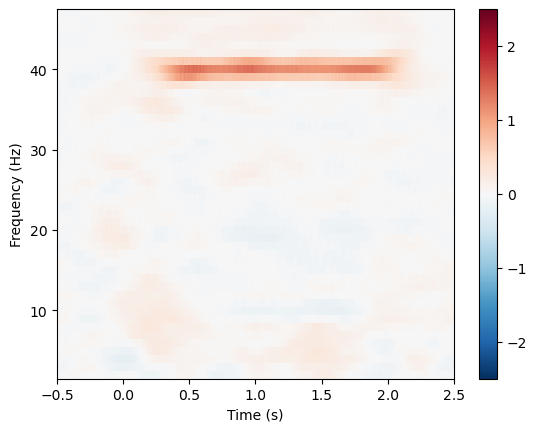

[<Figure size 640x480 with 2 Axes>]

In [9]:
tfr_induced[0].plot(
    picks=['eeg'],
    tmin=-0.5, tmax=2.5, 
    mode = "percent",
    combine = "mean",
    baseline = [-.8, -.1],
    vmin=-2.5, vmax=2.5)  

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: percent)


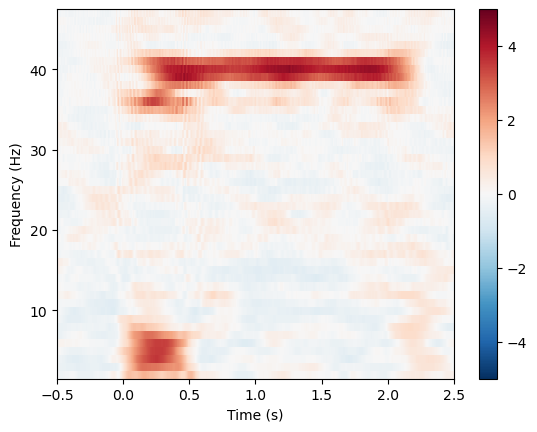

[<Figure size 640x480 with 2 Axes>]

In [10]:
tfr_induced[1].plot(
    picks=['eeg'],
    tmin=-0.5, tmax=2.5, 
    mode = "percent",
    combine = "mean",
    baseline = [-.8, -.1],
    vmin=-5, vmax=5)  

In [20]:
fs = 1000
t = np.arange(0, 2, 1/fs)
f = 40 # frequency in Hz
A = 1 # amplitude
sine_wave = A * np.sin(2*np.pi*f*t)

stimsig = np.concatenate([np.zeros((1000,)), sine_wave, np.zeros((1001,))])
stimsig3D = np.tile(stimsig, (125, 1)).reshape(125, 1, -1)

info = mne.create_info(['StimSig'], ch_types = ["misc"], sfreq=1000)
epochs_stim = mne.EpochsArray(stimsig3D, info)

newepochs = epochs.copy().add_channels([epochs_stim],force_update_info=True)



Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated


In [34]:
picks = mne.pick_types(newepochs.info, eeg=True)

indices = (np.repeat(len(newepochs.ch_names)-1,len(picks)),    # row indices
          picks)

con = spectral_connectivity_epochs(
    newepochs, indices=indices,
    method='coh', mode='multitaper', 
    mt_bandwidth = 2,
    fmin = 2, fmax = 48, n_jobs=1)

Replacing existing metadata with 3 columns
Connectivity computation...
    computing connectivity for 254 connections
    using t=-1.000s..3.000s for estimation (4001 points)


    frequencies: 2.2Hz..48.0Hz (184 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    comput

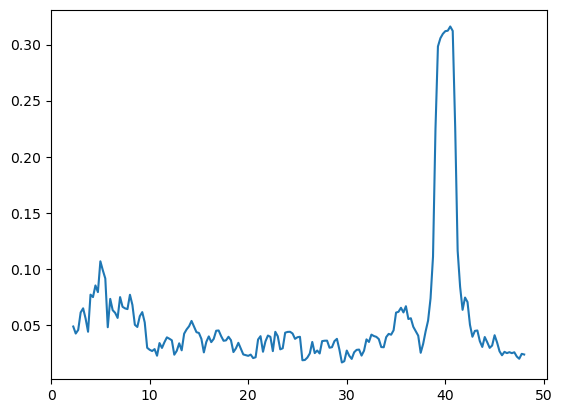

In [35]:
plt.plot(con.freqs, np.mean(con.get_data(), axis = 0))

In [113]:
newepochs.ch_names[259]

'StimSig'

In [116]:
#con_tfr = spectral_connectivity_time(newepochs, indices=indices,

cwt_freqs = np.arange(10, 48, 2)
cwt_n_cycles = cwt_freqs / 2.

con_tfr = spectral_connectivity_epochs(newepochs, indices=(np.array([259]),np.array([ind40Hz])),
    method='coh', mode='cwt_morlet',  
    cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles)

Replacing existing metadata with 3 columns
Connectivity computation...


    computing connectivity for 1 connections
    using t=-1.000s..3.000s for estimation (4001 points)
    frequencies: 10.0Hz..46.0Hz (19 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epo

/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/methcogneurocode/.venv/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:270: RuntimeWarning: invalid value encountered in divide
  self.con_scores[con_idx] = np.abs(csd_mean) / np.sqrt(psd_xx * psd_yy)


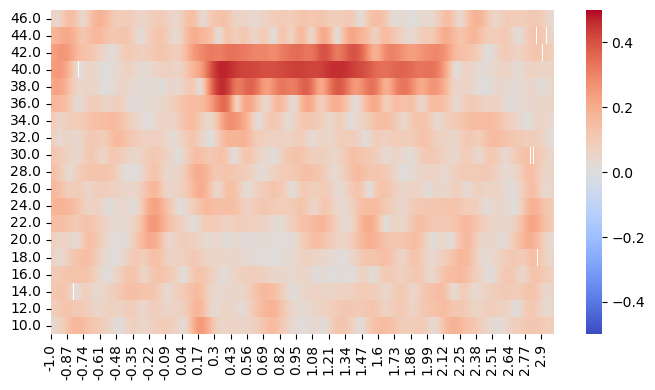

In [125]:
cohMat = np.squeeze(con_tfr.get_data())
df_coh = pd.DataFrame(data=cohMat, columns=con_tfr.times, index=con_tfr.freqs)

plt.figure(figsize = (7,4))
ax = sns.heatmap(df_coh, vmin = -.5, vmax = .5, cmap = "coolwarm")
ax.invert_yaxis()
plt.show()

## Low frequency stimulation

In [126]:
info = mne.io.read_info("sample-info.fif", verbose = True)
info = mne.Info(info, sfreq=100)

datapath = "/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/Lecture3_Decoding/data/dataset4nathan.mat"
epochs3Hz = mne.read_epochs_fieldtrip(datapath, info)

Adding metadata with 3 columns
2845 matching events found
No baseline correction applied


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/methcogneurocode/.venv/lib/python3.11/site-packages/mne/viz/evoked.py:577: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()  # for axes plots update axes.
/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/methcogneurocode/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


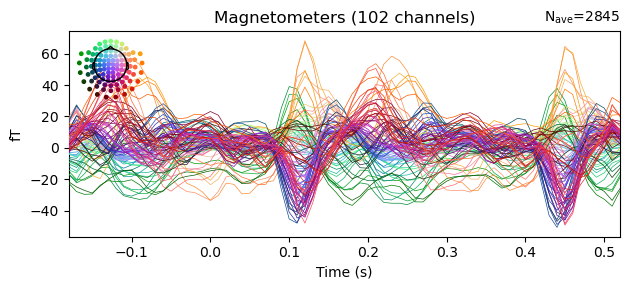

In [129]:
evoked3Hz = epochs3Hz.copy().average()
evoked3Hz.plot();

Effective window size : 0.710 (s)


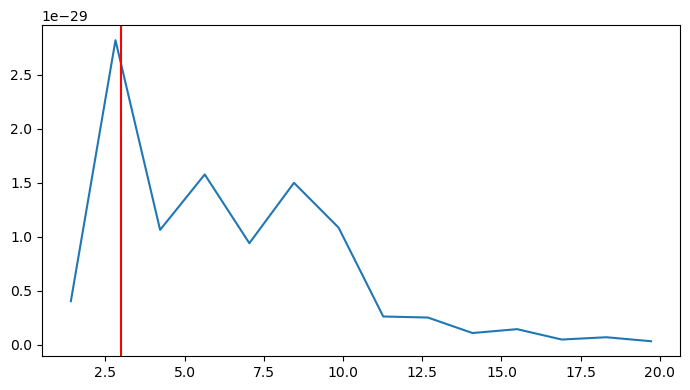

In [161]:
psdevoked3HZ = evoked3Hz.copy().compute_psd(method='welch', fmin=1, fmax=20)

plt.figure(figsize = (7,4))
plt.plot(psdevoked3HZ.freqs, psdevoked3HZ.get_data().mean(axis=0));
plt.axvline(x = 3, color = 'r');

**The peak is not exactly at 3 Hz (indicated by red line). Why?**